In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)


ae_dir = os.path.join(project_dir, 'modules/AutoEncoder')
if ae_dir not in sys.path:
    sys.path.append(ae_dir)

ipdl_dir = os.path.join(project_dir, 'modules/IPDL')
if ipdl_dir not in sys.path:
    sys.path.append(ipdl_dir)

import torch
from torch import nn
from torch.distributions import MultivariateNormal
import numpy as np
from matplotlib import pyplot as plt
from torch.utils.tensorboard import SummaryWriter


from autoencoder import SDAE, SDAE_TYPE

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Adversarial AutoEncoder architecture

In [2]:
z_dim = 2
sdae = SDAE([28*28, 1024, 1024, z_dim], SDAE_TYPE.linear, dropout=False, 
            activation_func=[nn.ReLU(), nn.ReLU(), nn.Identity()])

In [3]:
# Discriminator
class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        r'''
            Parameters
            ----------
                input_dim: int
                    Indicate the dimensionality of latent space Z

                hidden_dim: int
        '''
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(*[
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Dropout(p=.2),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        ])  
    def forward(self, x):
        return self.D(x)

In [4]:
# Encoder
Q = sdae.encode.to(device)

# Decoder
P = sdae.decode.to(device)

# Discriminator
D = Discriminator(z_dim, 512).to(device)

# Dataset
## Train

In [5]:
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import Subset, DataLoader

dataset_full = MNIST('data/', train = True, download = True, transform = transforms.ToTensor())
idx = torch.where((dataset_full.targets == 0) | (dataset_full.targets == 2))[0]

x_train_set = Subset(dataset_full, idx)
train_loader =  DataLoader(x_train_set, 128, shuffle=True)

tensor(0)


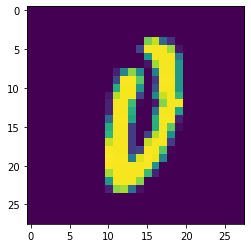

In [6]:
# TO REMOVE! Just testing!
x, y = next(iter(train_loader))
plt.imshow(x[0,0])
print(y[0])

## Test

In [7]:
test_dataset_full = MNIST('data/', train=False, download=True, transform = transforms.ToTensor())
idx_0 = torch.where(test_dataset_full.targets == 0)[0]
idx_2 = torch.where(test_dataset_full.targets == 2)[0]

test_dataset_0 = Subset(test_dataset_full, idx_0)
test_dataset_2 = Subset(test_dataset_full, idx_2)
test_loader_0 =  DataLoader(test_dataset_0, 512, shuffle=False)
test_loader_2 =  DataLoader(test_dataset_2, 512, shuffle=False)

## Defining 2-Dimensional Guassian as prior
$p(z) \sim \mathcal{N}_n(\mu, \sum)$

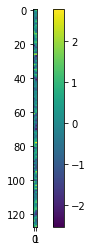

In [8]:
prior = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2))

plt.imshow(prior.sample((128,)))
plt.colorbar()
plt.show()

# Training

In [9]:
# Set learning rates
gen_lr = 1e-4
reg_lr = 5e-5

#encode/decode optimizers
optim_P = torch.optim.Adam(P.parameters(), lr=gen_lr)
optim_Q_enc = torch.optim.Adam(Q.parameters(), lr=gen_lr)
#regularizing optimizers
optim_Q_gen = torch.optim.Adam(Q.parameters(), lr=reg_lr)
optim_D = torch.optim.Adam(D.parameters(), lr=reg_lr)

In [10]:
n_epoch = 120
recons_criterion = nn.MSELoss()
# recons_criterion = nn.BCELoss()
eps = 1e-12
tb_writer = SummaryWriter('log/AAE')

for epoch in range(n_epoch):
    recons_loss_ = []
    disc_loss_ = []
    gen_loss_ = []
    Q.train()
    P.train()
    for idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.flatten(1)
        optim_P.zero_grad()
        optim_Q_enc.zero_grad()
        optim_Q_gen.zero_grad()
        optim_D.zero_grad()

        # Reconstruction loss
        z = Q(inputs)
        out = P(z)

        recon_loss = recons_criterion(out, inputs)
        recons_loss_.append(recon_loss.item())

        recon_loss.backward()
        optim_P.step()
        optim_Q_enc.step()

        # Discriminator
        # Prior as an multivariate gaussian function $p(z) \sim \mathcal{N}_n(\mu, \sum)$
        # this is constraining the Z-projection to be normal!
        Q.eval()
        z_real_gauss = prior.sample((inputs.size(0),)).to(device)
        D_real_gauss = D(z_real_gauss)

        z_fake_gauss = Q(inputs)
        D_fake_gauss = D(z_fake_gauss)

        D_loss = -torch.mean(torch.log(D_real_gauss + eps) + torch.log(1 - D_fake_gauss + eps))
        disc_loss_.append(D_loss.item())

        D_loss.backward()
        optim_D.step()

        # Generator
        Q.train()
        z_fake_gauss = Q(inputs)
        D_fake_gauss = D(z_fake_gauss)
        
        G_loss = -torch.mean(torch.log(D_fake_gauss + eps))
        gen_loss_.append(G_loss.item())

        G_loss.backward()
        optim_Q_gen.step()

    tb_writer.add_scalar('train/reconstruction', np.array(recons_loss_).mean(), epoch)
    tb_writer.add_scalar('train/Discrimator', np.array(disc_loss_).mean(), epoch)
    tb_writer.add_scalar('train/Generator', np.array(gen_loss_).mean(), epoch)
    
    Q.eval()
    P.eval()
    with torch.no_grad():
        loss_0 = []
        loss_2 = []
        for inputs, _ in test_loader_0:
            inputs = inputs.to(device).flatten(1)
            z = Q(inputs)
            out = P(z)
            
            loss_0.append(recons_criterion(out, inputs).item())

        for inputs, _ in test_loader_2:
            inputs = inputs.to(device).flatten(1)
            z = Q(inputs)
            out = P(z)
            
            loss_2.append(recons_criterion(out, inputs).item())
        

        tb_writer.add_scalar('test/reconstruction/0', np.array(loss_0).mean(), epoch)
        tb_writer.add_scalar('test/reconstruction/2',np.array(loss_2).mean(), epoch)

In [13]:
z = Q(inputs)
out = P(z)

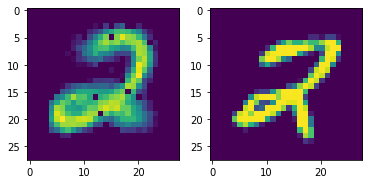

In [62]:
idx = np.random.randint(0, len(inputs)-1)
test_in = inputs[idx].reshape(28,28)
test_out = out[idx].reshape(28,28)

plt.subplot(1,2,1)
plt.imshow(test_out.cpu().detach())
plt.subplot(1,2,2)
plt.imshow(test_in.cpu().detach())
plt.show()

In [ ]:
x,y = next(iter(test_loader_2))
y

In [ ]:
Q.eval()
P.eval()
with torch.no_grad():
    loss_0 = []
    for inputs, _ in test_loader_0:
        inputs = inputs.to(device).flatten(1)
        z = Q(inputs)
        out = P(z)
        
        loss_0.append(recons_criterion(out, inputs).item())
    
    print(np.array(loss_0).mean())